This notebook loads a trained model and deploys it using the appropriate test dataset

In [1]:
import os
import torch
import numpy as np
import cv2 as cv
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# My stuff
import ae
import utils
from dataloader import LArCV_loader

In [3]:
# Set the root path of the particle generator experiments folder
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

In [4]:
# Set the dir of the particular experiment to be deployed
exp_dir = "01-05-2020_12-32-49_ae_7500_epochs_LArCV_64_dataset/"

In [5]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir)
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/01-05-2020_12-32-49_ae_7500_epochs_LArCV_64_dataset/


In [6]:
# Path to model weights
weights_dir = "weights/"

In [7]:
# Path to the test data
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/"

In [8]:
# Set up the torch dataloader
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
test_dataset    = LArCV_loader(root = test_data, transforms = test_transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [9]:
dataloader = DataLoader(test_dataset, **loader_kwargs)

In [10]:
# Set the GPU (GPU 1 is the best option)
device = torch.device(2)

In [11]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [12]:
print(config_df)

        Unnamed: 0                                                  0
0         n_layers                                                  4
1        exp_label  01-05-2020_12-32-49_ae_7500_epochs_LArCV_64_da...
2            z_dim                                                100
3          shuffle                                               True
4                p                                                0.9
5       num_epochs                                               7500
6        data_root  /media/hdd1/kai/particle_generator/larcv_data/...
7          dataset                                                 64
8         save_dir  /media/hdd1/kai/particle_generator/experiments...
9        save_root    /media/hdd1/kai/particle_generator/experiments/
10    weights_save  /media/hdd1/kai/particle_generator/experiments...
11          ae_opt                                               adam
12           l_dim                                                 20
13           g_opt  

In [13]:
# Get the model architecture from config df
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].item())**2
im_dim   = int(np.sqrt(im_size))

In [14]:
# Set up AE layer sizes
base = [256] 

# Compute encoder sizes
sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
enc_sizes = base * n_layers
enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

# Update kwarg dicts
# Decoder is the reverse of the encoder
ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}

In [15]:
# Get checkpoint name(s)
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [18]:
print("-"*60)
for i in range(len(checkpoint_names)):
    print("\n {} :".format(str(i)), checkpoint_names[i], '\n')
    print("-"*60)

------------------------------------------------------------

 0 : /media/hdd1/kai/particle_generator/experiments/01-05-2020_12-32-49_ae_7500_epochs_LArCV_64_dataset/weights/best_ae_ep_5250.tar 

------------------------------------------------------------

 1 : /media/hdd1/kai/particle_generator/experiments/01-05-2020_12-32-49_ae_7500_epochs_LArCV_64_dataset/weights/best_ae_ep_6500.tar 

------------------------------------------------------------


In [19]:
best_checkpoint = checkpoint_names[0]

In [20]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(best_checkpoint)

In [21]:
# Load the model on GPU
model = ae.AutoEncoder(**ae_kwargs).to(device)

In [22]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
model.load_state_dict(checkpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
# Put the model in evaluation mode
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (fc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4096, out_features=2048, bias=True)
        (1): ReLU(inplace)
      )
      (1): Sequential(
        (0): Linear(in_features=2048, out_features=1024, bias=True)
        (1): ReLU(inplace)
      )
      (2): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): ReLU(inplace)
      )
      (3): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU(inplace)
      )
    )
    (last): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc_blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        

In [24]:
test_ims = []; samples = []; limit = 9

for idx, image in enumerate(dataloader):
    # Flatten image into a vector
    image = image.view(1, -1).to(device)
    
    # Get sample from model
    sample = model(image)
        
    # Undo image normalization
#     image = (image * 0.5) + 0.5
#     sample = (sample * 0.5) + 0.5
    
    # Remove the gradient requirement, move to cpu memory, and conver to numpy
    image = image.view(-1, im_dim, im_dim).detach().cpu().numpy()
    sample = sample.view(-1, im_dim, im_dim).detach().cpu().numpy()
    
    # Concatenate the two images along the channel dimension and append to list
    test_ims.append(image)
    samples.append(sample)
    
    if idx == limit:
        break

In [28]:
# Check samples list
print("-"*60)
print("Test ims: ", len(test_ims))
print("Test image dims: ", test_ims[0][0].shape)
print("-"*60)
print("Samples: ", len(samples)) 
print("Sample dims: ", samples[0][0].shape)
print("-"*60)

------------------------------------------------------------
Test ims:  10
Test image dims:  (64, 64)
------------------------------------------------------------
Samples:  10
Sample dims:  (64, 64)
------------------------------------------------------------


### Visualize the deploy samples

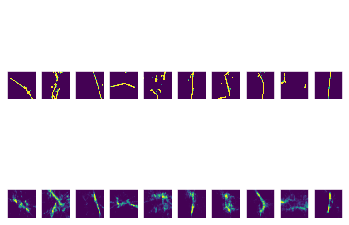

In [29]:
n_row = 2; n_col = limit + 1

fig, axes = plt.subplots(n_row, n_col)
supTitle = "{} Model deploy samples using {}x{} dataset".format('AE', im_dim, im_dim)
fig.suptitle(supTitle, color="white")

img = None; test_num = limit; sample_num = limit
for i in range(0, n_row):
    for j in range(0, n_col):
        if i == 0:
            img = axes[i,j].imshow( test_ims[test_num][0] )
            test_num -= 1
        else:
            img = axes[i,j].imshow( samples[sample_num][0] )
            sample_num -= 1
        axes[i,j].spines['bottom'].set_color('white')
        axes[i,j].spines['top'].set_color('white')
        axes[i,j].spines['left'].set_color('white')
        axes[i,j].spines['right'].set_color('white')
        axes[i,j].xaxis.label.set_color('white')
        axes[i,j].yaxis.label.set_color('white')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].tick_params(axis='x', colors='#443941')
        axes[i,j].tick_params(axis='y', colors='#443941')

# Colorbar
# cbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# cbar = plt.colorbar(img, cax=cbar_axes)
# cbar.ax.yaxis.set_tick_params(color="white")
# cbar.outline.set_edgecolor(color="white")
# plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color="white")

plt.savefig("{}_model_deploy_samples_{}_dataset.png".format('AE', im_dim), dpi=300, facecolor='#443941')